## Neural Networks with Gluon

In this notebook, we build, train and validate a Neural Network in Gluon. 

In [1]:
# Importing the necessary libraries
import time
import d2l
import mxnet as mx
from mxnet import gluon, autograd, np, npx
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

npx.set_np()

### 1. Implementing a neural network with Gluon

Let's implement a simple neural network with two hidden layers of size 64 and 128 using the sequential mode (Adding things in sequence). We will have 3 inputs, 2 hidden layers and 1 output layer. Some drop-outs attached to the hidden layers.

In [2]:
from mxnet.gluon import nn

net = nn.Sequential()

net.add(nn.Dense(64,                    # Dense layer-1 with 64 units
                 in_units=3,            # Input size of 3 is expected
                 activation='tanh'),    # Tanh activation is applied
        nn.Dropout(.4),                 # Apply random 40% drop-out to layer_1
        
        nn.Dense(128,                   # Dense layer-2 with 128 units  
                 activation='tanh'      # Tanh activation is applied
                ),
        nn.Dropout(.3),                 # Apply random 30% drop-out to layer_2
        
        nn.Dense(1))                    # Output layer with single unit

print(net)

Sequential(
  (0): Dense(3 -> 64, Activation(tanh))
  (1): Dropout(p = 0.4, axes=())
  (2): Dense(-1 -> 128, Activation(tanh))
  (3): Dropout(p = 0.3, axes=())
  (4): Dense(-1 -> 1, linear)
)


We can initialize the weights of the network with 'initialize()' function. We prefer to use the following:

In [3]:
from mxnet import init

net.initialize(init=init.Xavier())

Let's look at our layers and dropouts on them. We can easily access them wth net[layer_index]

In [4]:
print(net[0])
print(net[1])
print(net[2])
print(net[3])
print(net[4])

Dense(3 -> 64, Activation(tanh))
Dropout(p = 0.4, axes=())
Dense(-1 -> 128, Activation(tanh))
Dropout(p = 0.3, axes=())
Dense(-1 -> 1, linear)


### 2. Loss Functions:

We will go over some popular loss functions here. We can select loss functions according to our problem.  <br/>
__Binary Cross-entropy Loss:__ A common loss function binary classification. It is given by: 
\begin{align}
-\frac{1}{n}\sum_{examples}{(y\log(p) + (1 - y)\log(1 - p))}
\end{align}
where p is the prediction (between 0 and 1, ie. 0.831) and y is the true class (either 1 or 0). 

In gluon, we can use binary cross entropy with `SigmoidBinaryCrossEntropyLoss`. It also applies sigmoid function on the predictions. Therefore, p is always between 0 and 1. <br/>
```python
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss
loss = SigmoidBinaryCrossEntropyLoss()
```
__Categorical Cross-entropy Loss:__ It is used for multi-class classification. We apply the softmax function on prediction probabilities and then extend the equation of binary cross-entropy. After the softmax function, summation of the predictions are equal to 1. For example: Assuming three classes, p_0= 0.22, p_1= 0.60 and p_2= 0.18 Equation is below. y becomes 1 for true class and 0 for other classes.
\begin{align} 
-\frac{1}{n}\sum_{examples}\sum_{classes}{y_j\log(p_j)}
\end{align}
In gluon, `SoftmaxCrossEntropyLoss` implements the categorical cross-entropy loss with softmax function <br/>
```python
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
loss = SoftmaxCrossEntropyLoss()
```
__Mean Squared Error (MSE):__ Used for regression problems. It is also called the "L2 loss". It measures mean the squared difference between target values (y) and predictions (p). Here, square makes sure the offsets with different signs don't cancel out each other.
\begin{align}
-\frac{1}{n}\sum_{examples}{(y-p)^2}
\end{align}
In gluon, we can use it with `L2Loss`: <br/>
```python
from mxnet.gluon.loss import L2Loss
loss = L2Loss()
```
__Mean Absolute Error (MAE):__ Slightly different version of MSE. It is also called the "L1 loss". It measures the abolsute difference between target values (y) and predictions (p). Again, the absolute operation gets rid of the sign and the offsets with different signs don't cancel out each other.
\begin{align}
-\frac{1}{n}\sum_{examples}{abs(y-p)}
\end{align}
In gluon, we can use it with `L1Loss`: <br/>
```python
from mxnet.gluon.loss import L1Loss
loss = L1Loss()
```

### 3. Training:

`mxnet.gluon.Trainer()` module provides necessary training algorithms for neural networks. We can use the following for training a network using Stochastic Gradient Descent method and learning rate of 0.001.

```python
from mxnet import gluon

trainer = gluon.Trainer(net.collect_params(),
                        'sgd', 
                        {'learning_rate': 0.001}
                       )
```

### 4. Example - Binary Classification

Let's train a neural network on a random dataset. We have two classes and will learn to classify them.

In [5]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3)

Let's plot the dataset

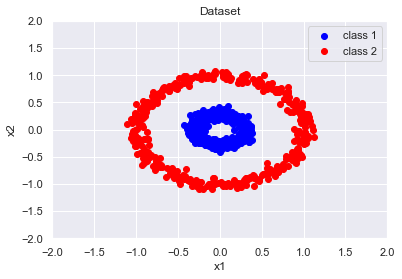

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset(X, y, title):
    
    # Activate Seaborn visualization
    sns.set()
    
    # Plot both classes: Class1->Blue, Class2->Red
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
    plt.legend(loc='upper right')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title(title)
    plt.show()
    
plot_dataset(X, y, title="Dataset")

We are creating the network below. We will have two hidden layers. Since the data seems easily seperable, we can have a small network with 10 units at each layer.

In [7]:
from mxnet import init
from mxnet.gluon import nn

net = nn.Sequential()
net.add(nn.Dense(10, in_units=2, activation='relu'),
        nn.Dense(10, activation='relu'),
        nn.Dense(1, activation='sigmoid'))
net.initialize(init=init.Xavier())

Let's start the training process. We will have training and validation sets and print our losses at each step.

In [8]:
def train(net, train_features, train_labels, val_features, val_labels,
          num_epochs, learning_rate, batch_size):
    
    ## convert to ndarray and load to dataloader
    train_features = np.array(train_features, dtype=np.float32)
    val_features = np.array(val_features, dtype=np.float32)
    train_labels = np.array(train_labels, dtype=np.float32).reshape(-1, 1)
    val_labels = np.array(val_labels, dtype=np.float32).reshape(-1, 1)
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    val_iter = d2l.load_array((val_features, val_labels), 
                              val_labels.shape[0])
    
    ## loss function
    binary_cross_loss = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    
    # The SGD optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                            {'learning_rate': learning_rate})
    train_losses, val_losses = [], [] #mx.np.array([], dtype=np.float32)
    for epoch in range(num_epochs):
        train_ls, val_ls = 0, 0
        for X, y in train_iter:
            with autograd.record():
                out = net(X)
                l = binary_cross_loss(out, y)
                l.backward()
            trainer.step(batch_size)
            train_ls += l.sum()        
        
        for val_X, val_y in val_iter:
            val_out = net(val_X)
            val_ls += binary_cross_loss(val_out, val_y).sum()
            
        # Let's take the average losses
        training_loss = train_ls / len(train_labels)
        val_loss = val_ls / len(val_labels)
        
        train_losses.append(training_loss)
        val_losses.append(val_loss)
        if epoch % 10 == 0:
            print("Epoch %s. Train_loss (mse) %s Validation_loss (mse) %s" \
                  % (epoch, training_loss, val_loss))
    ## print last epoch
    print("Epoch %s. Train_loss (mse) %s Validation_loss (mse) %s" \
          % (epoch, training_loss, val_loss))
    predictions = np.round(val_out)
    return train_losses, val_losses, predictions

In [9]:
batch_size = 16          # How many samples to use for each weight update 
epochs = 50              # Total number of iterations
learning_rate = 0.01     # Learning rate
context = mx.cpu()       # Using CPU resource


# Splitting the dataset into two parts: 80%-20% split
X_train, X_val = X[0:int(len(X)*0.8), :], X[int(len(X)*0.8):, :]
y_train, y_val = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

train_losses, val_loss, val_predictions = \
    train(net=net, train_features=X_train, train_labels=y_train, 
      val_features=X_val, val_labels=y_val,
      num_epochs=epochs, learning_rate=learning_rate, 
      batch_size=batch_size)

Epoch 0. Train_loss (mse) 0.72527844 Validation_loss (mse) 0.71432686
Epoch 10. Train_loss (mse) 0.66589385 Validation_loss (mse) 0.665481
Epoch 20. Train_loss (mse) 0.6211658 Validation_loss (mse) 0.62164176
Epoch 30. Train_loss (mse) 0.5584254 Validation_loss (mse) 0.55905616
Epoch 40. Train_loss (mse) 0.46512857 Validation_loss (mse) 0.46504608
Epoch 49. Train_loss (mse) 0.3645719 Validation_loss (mse) 0.36494288


Let's see the validation predictions.

In [10]:
val_predictions

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],

Let's see the training and validation loss plots below. Losses go down as the training process continues as expected.

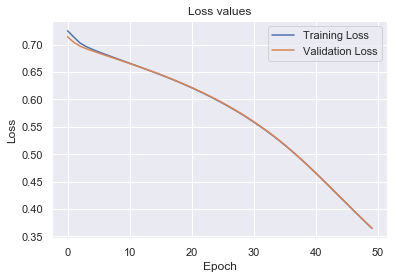

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 5. Natural Language Processing Context:

If we want to use the same type of architecture for text classification, we need to apply some feature extraction methods first. For example: We can get TF-IDF vectors of text fields. After that, we can use neural networks on those features. 

We will also look at __more advanced neural network architrectures__ such as __Recurrent Neural Networks (RNNs)__, __Long Short-Term Memory networks (LSTMs)__ and __Transformers__. 